### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [206]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [208]:
# Load the datasets
activities_train_df = pd.read_csv('Activities_train.csv')
projects_train_df = pd.read_csv('Projects_train.csv')
grants_df = pd.read_csv('Grants.csv')
landscape_df = pd.read_csv('Landscape.csv')
subawards_df = pd.read_csv('Subawards_train.csv')
acad_regional_df = pd.read_csv('ACADRegional.csv')
reserves_df = pd.read_csv('Reserves.csv')
#print(projects_train_df.head())
# Clean column names (if needed) to remove leading or trailing spaces
reserves_df.columns = reserves_df.columns.str.strip()

In [209]:
# Remove rows with missing ProjectPriority values
projects_train_df = projects_train_df.dropna(subset=['ProjectPriority'])
projects_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, 0 to 90
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ProjectName        88 non-null     int64 
 1   ProgramName        88 non-null     object
 2   ProjectManager     88 non-null     object
 3   RegionName         88 non-null     object
 4   ReserveName        88 non-null     object
 5   SpeciesCommonName  88 non-null     object
 6    EstimatedCost     88 non-null     object
 7   ProjectPriority    88 non-null     object
dtypes: int64(1), object(7)
memory usage: 6.2+ KB


In [211]:
#Estimated cost has a space ahead of it
# Remove leading and trailing whitespace from all column names
projects_train_df.columns = projects_train_df.columns.str.strip()
#Convert EstimatedCost to a numeric format by removing dollar signs and commas
projects_train_df['EstimatedCost'] = projects_train_df['EstimatedCost'].replace('[\$,]', '', regex=True).astype(float)

# Verify the result
print(projects_train_df.head())

   ProjectName ProgramName ProjectManager RegionName   ReserveName  \
0            4       MIMAL              F      BCR23         Karuk   
1            8     Central              C      BCR35     Nankipooh   
2            9       MIMAL              B      BCR23         Karuk   
3           10  Crossroads              I      BCR29      Weracoba   
4           11       MIMAL              C      BCR26  Acoma Pueblo   

           SpeciesCommonName  EstimatedCost ProjectPriority  
0          Red-billed Pigeon     37000000.0          Medium  
1      Tawny-crested Tanager      6000000.0          Medium  
2   White-bellied Chachalaca     15000000.0            High  
3  Black-cheeked Ant-Tanager     23000000.0            High  
4                  King Rail     47000000.0            High  


In [212]:
# Calculate 'Budget - Spend' in Subawards
subawards_df['BudgetMinusSpend'] = subawards_df['Budget'] - subawards_df['Spend']

print(subawards_df.head())


   SubAwardName  ProjectName VendorName  ActivityName      Budget     Spend  \
0             4            4    ABC INC             4   98340.864   92774.4   
1             8            8    LOL INC             8  116083.800  139860.0   
2             9            9        IFM             9    8700.615   10741.5   
3            10           10        NDR            10    4872.000    4200.0   
4            11           11       WFYF            11   93634.464   88334.4   

   BudgetMinusSpend  
0          5566.464  
1        -23776.200  
2         -2040.885  
3           672.000  
4          5300.064  


In [213]:
# Standardize key columns by removing whitespaces and converting to lowercase
activities_train_df['ProjectName'] = activities_train_df['ProjectName'].astype(str).str.strip().str.lower()
activities_train_df['ActivityName'] = activities_train_df['ActivityName'].astype(str).str.strip().str.lower()
activities_train_df['TreeName'] = activities_train_df['TreeName'].astype(str).str.strip().str.lower()
projects_train_df['ProjectName'] = projects_train_df['ProjectName'].astype(str).str.strip().str.lower()
subawards_df['ActivityName'] = subawards_df['ActivityName'].astype(str)
grants_df['GrantName'] = grants_df['GrantName'].astype(str).str.strip().str.lower()
landscape_df['TreeName'] = landscape_df['TreeName'].astype(str).str.strip().str.lower()

# Verify that the key columns are standardized
# print(activities_train_df[['ProjectName', 'ActivityName', 'TreeName']].head())
# print(projects_train_df['ProjectName'].head())
# print(grants_df['GrantName'].head())
# print(landscape_df['TreeName'].head())


In [214]:
# Aggregate activity features by ProjectName
activities_agg = activities_train_df.groupby('ProjectName').agg({
    'ActivityName': 'count',          # Total Number of Activities
}).reset_index()

# Rename columns for clarity
activities_agg.rename(columns={
    'ActivityName': 'TotalActivities',
}, inplace=True)

# Display the aggregated features
print(activities_agg.head())


  ProjectName  TotalActivities
0          10               17
1          11               13
2          12               12
3          13               10
4          14               11


In [215]:
# Merge Landscape data to get cost per tree
activities_with_cost = pd.merge(activities_train_df, landscape_df[['TreeName', 'CostperTree']], on='TreeName', how='left')

# Calculate total activity cost per project
activities_with_cost['TotalActivityCost'] = activities_with_cost['NumberofTrees'] * activities_with_cost['CostperTree']

In [216]:
# Merge Subawards with Activities on 'ActivityName'
activities_with_cost = pd.merge(activities_with_cost, subawards_df[['ActivityName', 'BudgetMinusSpend']], on='ActivityName', how='left')

# Calculate 'Cost of Activity - (Budget - Spend)' and create a new column
print(activities_with_cost.head())
#not a proper join- missing values--

# Find activity names in Activities that don’t have a matching BudgetMinusSpend
#missing_matches = activities_with_cost[activities_with_cost['BudgetMinusSpend'].isna()]
#print("Activities without matching subawards:\n", missing_matches[['ActivityName', 'ProjectName']])

# Fill NaNs in BudgetMinusSpend with 0 as if empty= means no award
activities_with_cost['BudgetMinusSpend'].fillna(0, inplace=True)

# Recalculate AdjustedActivityCost after filling NaNs
activities_with_cost['AdjustedActivityCost'] = np.where(
    activities_with_cost['BudgetMinusSpend'] > 0,
    activities_with_cost['TotalActivityCost'] - activities_with_cost['BudgetMinusSpend'],
    activities_with_cost['TotalActivityCost'] + activities_with_cost['BudgetMinusSpend']
)
# Display the updated DataFrame to verify
print(activities_with_cost[['ActivityName', 'TotalActivityCost', 'BudgetMinusSpend', 'AdjustedActivityCost']].head())

  ActivityName ProjectName         GrantName       Reserve          TreeName  \
0            0          17  CardboardGrant23     Kalispell  indian rose wood   
1            1          61  CardboardGrant23     Blackfeet           avocado   
2            2           9    BasketGrant283         Karuk            spruce   
3            3          79       PaperGrant5        Arouca            peepal   
4            4          20     GlassGrant209  Acoma Pueblo           avocado   

   NumberofTrees  CostperTree  TotalActivityCost  BudgetMinusSpend  
0          12700         17.0           215900.0               NaN  
1           8580         16.0           137280.0               NaN  
2           4428         20.0            88560.0               NaN  
3          10137          8.0            81096.0               NaN  
4          19328         16.0           309248.0          5566.464  
  ActivityName  TotalActivityCost  BudgetMinusSpend  AdjustedActivityCost
0            0           215900

In [217]:
# Aggregate total activity cost by ProjectName
cost_agg = activities_with_cost.groupby('ProjectName')['AdjustedActivityCost'].sum().reset_index()

# Verify the aggregated cost data
print(cost_agg.head())

  ProjectName  AdjustedActivityCost
0          10          1.114847e+06
1          11          2.290907e+06
2          12          2.393944e+05
3          13          1.779719e+06
4          14          1.676225e+06


In [218]:
# Merge aggregated activity features and activity costs
train_merged = pd.merge(activities_agg, cost_agg, on='ProjectName', how='left')
train_merged = pd.merge(projects_train_df, train_merged, on='ProjectName', how='left')
# Verify the final merged dataset for training
print(train_merged.head())


  ProjectName ProgramName ProjectManager RegionName   ReserveName  \
0           4       MIMAL              F      BCR23         Karuk   
1           8     Central              C      BCR35     Nankipooh   
2           9       MIMAL              B      BCR23         Karuk   
3          10  Crossroads              I      BCR29      Weracoba   
4          11       MIMAL              C      BCR26  Acoma Pueblo   

           SpeciesCommonName  EstimatedCost ProjectPriority  TotalActivities  \
0          Red-billed Pigeon     37000000.0          Medium                9   
1      Tawny-crested Tanager      6000000.0          Medium               10   
2   White-bellied Chachalaca     15000000.0            High               14   
3  Black-cheeked Ant-Tanager     23000000.0            High               17   
4                  King Rail     47000000.0            High               13   

   AdjustedActivityCost  
0          4.771501e+05  
1          3.943973e+05  
2          7.327355e+05  


In [219]:
#including risk index from speciesrisks
# Load the dataset
species_risks_df = pd.read_csv('SpeciesRisks.csv')
#there is a 'SpeciesCommonName' column that matches 'SpeciesCommonName' in Activities_train.csv
# Merge risk data with Activities_train.csv using 'SpeciesName' as the key
train_merged = pd.merge(train_merged, species_risks_df[['SpeciesCommonName', 'RiskIndex']], on='SpeciesCommonName', how='left')

# Verify the merged dataset
print(train_merged.head())

  ProjectName ProgramName ProjectManager RegionName   ReserveName  \
0           4       MIMAL              F      BCR23         Karuk   
1           8     Central              C      BCR35     Nankipooh   
2           9       MIMAL              B      BCR23         Karuk   
3          10  Crossroads              I      BCR29      Weracoba   
4          11       MIMAL              C      BCR26  Acoma Pueblo   

           SpeciesCommonName  EstimatedCost ProjectPriority  TotalActivities  \
0          Red-billed Pigeon     37000000.0          Medium                9   
1      Tawny-crested Tanager      6000000.0          Medium               10   
2   White-bellied Chachalaca     15000000.0            High               14   
3  Black-cheeked Ant-Tanager     23000000.0            High               17   
4                  King Rail     47000000.0            High               13   

   AdjustedActivityCost  RiskIndex  
0          4.771501e+05       0.10  
1          3.943973e+05       

In [220]:
#Using Reserves
# Calculate TotalUnusedArea
reserves_df['TotalUnusedArea'] = reserves_df['TotalReserveArea'] - reserves_df['TotalReserveUsed']

# Calculate PotentialAreaToPlantTree
reserves_df['PotentialAreaToPlantTree'] = reserves_df['TotalUnusedArea'] * reserves_df['PackingDensity']

# Check the resulting DataFrame
#print(reserves_df[['ReserveName', 'TotalReserveArea', 'TotalReserveUsed', 'TotalUnusedArea', 'PackingDensity', 'PotentialAreaToPlantTree']].head())

# Now merge this new data with your main DataFrame (e.g., `train_merged`) on 'ReserveName' or any other matching key
train_merged = pd.merge(train_merged, reserves_df[['ReserveName', 'PotentialAreaToPlantTree']], on='ReserveName', how='left')

# Fill any missing values with 0 (if no data for certain reserves)
train_merged['PotentialAreaToPlantTree'].fillna(0, inplace=True)

# Check the top rows to verify the merge
print(train_merged.head())

  ProjectName ProgramName ProjectManager RegionName   ReserveName  \
0           4       MIMAL              F      BCR23         Karuk   
1           8     Central              C      BCR35     Nankipooh   
2           9       MIMAL              B      BCR23         Karuk   
3          10  Crossroads              I      BCR29      Weracoba   
4          11       MIMAL              C      BCR26  Acoma Pueblo   

           SpeciesCommonName  EstimatedCost ProjectPriority  TotalActivities  \
0          Red-billed Pigeon     37000000.0          Medium                9   
1      Tawny-crested Tanager      6000000.0          Medium               10   
2   White-bellied Chachalaca     15000000.0            High               14   
3  Black-cheeked Ant-Tanager     23000000.0            High               17   
4                  King Rail     47000000.0            High               13   

   AdjustedActivityCost  RiskIndex  PotentialAreaToPlantTree  
0          4.771501e+05       0.10       

In [221]:
# Prepare features and target variable
X = train_merged[['AdjustedActivityCost', 'TotalActivities', 'RiskIndex', 'PotentialAreaToPlantTree']]
y = train_merged['ProjectPriority']

# Encode target variable
priority_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
y = y.map(priority_mapping)

# Verify features and target
print(X.head())
print(y.head())


   AdjustedActivityCost  TotalActivities  RiskIndex  PotentialAreaToPlantTree
0          4.771501e+05                9       0.10                    4995.0
1          3.943973e+05               10       0.98                    1440.0
2          7.327355e+05               14       0.19                    4995.0
3          1.114847e+06               17       0.82                      52.5
4          2.290907e+06               13       0.58                    1534.0
0    1
1    1
2    2
3    2
4    2
Name: ProjectPriority, dtype: int64


In [222]:
# Split data into training and validation sets (for internal model tuning and evaluation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify indices of NaN values in y_train
nan_indices = y_train[y_train.isna()].index

# Drop rows with NaN values in both X_train and y_train
X_train = X_train.drop(nan_indices).copy()
y_train = y_train.drop(nan_indices).copy()

# Ensure y_train is integer type
y_train = y_train.astype(int)

# Verify no more NaN values
#print("Number of NaN values in y_train:", y_train.isna().sum())


In [223]:
# # Initialize the scaler
# scaler = StandardScaler()

# # Fit and transform the training data
# X_train_scaled = scaler.fit_transform(X_train[['AdjustedActivityCost', 'TotalActivities', 'RiskIndex', 'PotentialAreaToPlantTree']])
# #print(X_train_scaled)
# X_train=X_train_scaled

In [224]:
import xgboost as xgb

# Train the model using the training set
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the XGBoost model
y_val_pred = xgb_model.predict(X_val)
print("Validation Accuracy with XGBoost:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report with XGBoost:\n", classification_report(y_val, y_val_pred))


Validation Accuracy with XGBoost: 0.7222222222222222
Validation Classification Report with XGBoost:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.71      0.62      0.67         8
           2       0.80      0.80      0.80         5

    accuracy                           0.72        18
   macro avg       0.73      0.74      0.73        18
weighted avg       0.72      0.72      0.72        18



In [225]:
#Tune Hyperparameters for XGBoost using GridSearch
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

xgb_model = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the tuned model
y_val_pred = best_model.predict(X_val)
print("Validation Accuracy after Hyperparameter Tuning:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report after Hyperparameter Tuning:\n", classification_report(y_val, y_val_pred))


Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Validation Accuracy after Hyperparameter Tuning: 0.6666666666666666
Validation Classification Report after Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.71      0.62      0.67         8
           2       0.75      0.60      0.67         5

    accuracy                           0.67        18
   macro avg       0.68      0.67      0.67        18
weighted avg       0.68      0.67      0.67        18



In [226]:
# Load the test datasets 
#Same preprocessing as Trainining data
activities_test_df = pd.read_csv('Activities_test.csv')
projects_test_df = pd.read_csv('Projects_test.csv')
subawards_test_df = pd.read_csv('Subawards_test.csv')
# Standardize key columns by removing whitespaces and converting to lowercase
activities_test_df['ProjectName'] = activities_test_df['ProjectName'].astype(str).str.strip().str.lower()
activities_test_df['TreeName'] = activities_test_df['TreeName'].astype(str).str.strip().str.lower()
subawards_df['ActivityName'] = subawards_df['ActivityName'].astype(str)
projects_test_df['ProjectName'] = projects_test_df['ProjectName'].astype(str).str.strip().str.lower()
projects_test_df.columns = projects_test_df.columns.str.strip()
#Convert EstimatedCost to a numeric format by removing dollar signs and commas
projects_test_df['EstimatedCost'] = projects_test_df['EstimatedCost'].replace('[\$,]', '', regex=True).astype(float)

#Calculate 'Budget - Spend' in Subawards Test
subawards_test_df['BudgetMinusSpend'] = subawards_test_df['Budget'] - subawards_test_df['Spend']
# Merge Landscape with Activities_test to calculate total cost per activity
activities_test_with_cost = pd.merge(activities_test_df, landscape_df[['TreeName', 'CostperTree']], on='TreeName', how='left')
activities_test_with_cost['TotalActivityCost'] = activities_test_with_cost['NumberofTrees'] * activities_test_with_cost['CostperTree']

#Merge Subawards Test with Activities Test on 'ActivityName'
activities_test_with_cost = pd.merge(activities_test_with_cost, subawards_test_df[['ActivityName', 'BudgetMinusSpend']], on='ActivityName', how='left')
# Fill NaNs in BudgetMinusSpend with 0 as if empty= means no award
activities_test_with_cost['BudgetMinusSpend'].fillna(0, inplace=True)
# Calculate 'AdjustedActivityCost' in the test set
activities_test_with_cost['AdjustedActivityCost'] = np.where(
    activities_test_with_cost['BudgetMinusSpend'] > 0,
    activities_test_with_cost['TotalActivityCost'] - activities_test_with_cost['BudgetMinusSpend'],
    activities_test_with_cost['TotalActivityCost'] + activities_test_with_cost['BudgetMinusSpend']
)

# Aggregate features from activities_test by ProjectName
activities_test_agg = activities_test_with_cost.groupby('ProjectName').agg({
    'ActivityName': 'count',          # Total Number of Activities
     'TotalActivityCost':'sum', # Number of Reserves involved
     'AdjustedActivityCost': 'sum'        # Total Activity Cost
}).reset_index()

# Rename columns for consistency
activities_test_agg.rename(columns={
    'ActivityName': 'TotalActivities',
     'TotalActivityCost': 'TotalActivityCost',
    'AdjustedActivityCost':'AdjustedActivityCost'
}, inplace=True)

# Merge aggregated activity features with Projects_test.csv
test_merged = pd.merge(projects_test_df, activities_test_agg, on='ProjectName', how='left')
# Merge the aggregated risk index with Projects_test.csv
test_merged = pd.merge(test_merged, species_risks_df[['SpeciesCommonName', 'RiskIndex']], on='SpeciesCommonName', how='left')
test_merged = pd.merge(test_merged, reserves_df[['ReserveName', 'PotentialAreaToPlantTree']], on='ReserveName', how='left')


# Prepare features for prediction
X_test = test_merged[['AdjustedActivityCost', 'TotalActivities', 'RiskIndex', 'PotentialAreaToPlantTree']]
print(X_test);

# Transform the test data
# X_test_scaled = scaler.transform(X_test[['AdjustedActivityCost', 'TotalActivities', 'RiskIndex', 'PotentialAreaToPlantTree']])
# X_test=X_test_scaled

   AdjustedActivityCost  TotalActivities  RiskIndex  PotentialAreaToPlantTree
0             320205.83               10       0.41                     211.2
1            1828496.00               11       0.49                     369.6
2             783222.00               12       0.54                    4949.0
3            3357789.00               15       0.10                    4746.0
4            1145529.00               17       0.85                     436.8
5             875465.00               15       0.86                       0.0
6            1557249.00               21       0.99                    1539.9
7             876292.00               11       0.39                    3553.2
8             962025.00                7       0.37                     768.4


In [227]:
# Predict on the provided test set
y_test_pred = best_model.predict(X_test)
#y_test_pred = xgb_model.predict(X_test)

# Print the predicted priorities for the test set
print("Predicted Project Priorities for Test Set:", y_test_pred)


Predicted Project Priorities for Test Set: [1 1 1 2 2 1 2 1 0]


In [228]:
#Testing
#ProjectPriority is given in Projects_test.csv, use it to compare with predictions
y_test_actual = projects_test_df['ProjectPriority']

# Encode the actual labels if necessary (e.g., 'Low' -> 0, 'Medium' -> 1, 'High' -> 2)
priority_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
y_test_actual = y_test_actual.map(priority_mapping)

from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
test_accuracy = accuracy_score(y_test_actual, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Generate classification report to see detailed metrics
print("Test Classification Report:\n", classification_report(y_test_actual, y_test_pred))


Test Accuracy: 0.5555555555555556
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.40      0.67      0.50         3
           2       0.67      0.67      0.67         3

    accuracy                           0.56         9
   macro avg       0.69      0.56      0.56         9
weighted avg       0.69      0.56      0.56         9



**FEATURE IMPORTANCE**

In [233]:
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


                    Feature  Importance
1           TotalActivities    0.624977
2                 RiskIndex    0.140433
3  PotentialAreaToPlantTree    0.126386
0      AdjustedActivityCost    0.108204


**VISUALS**

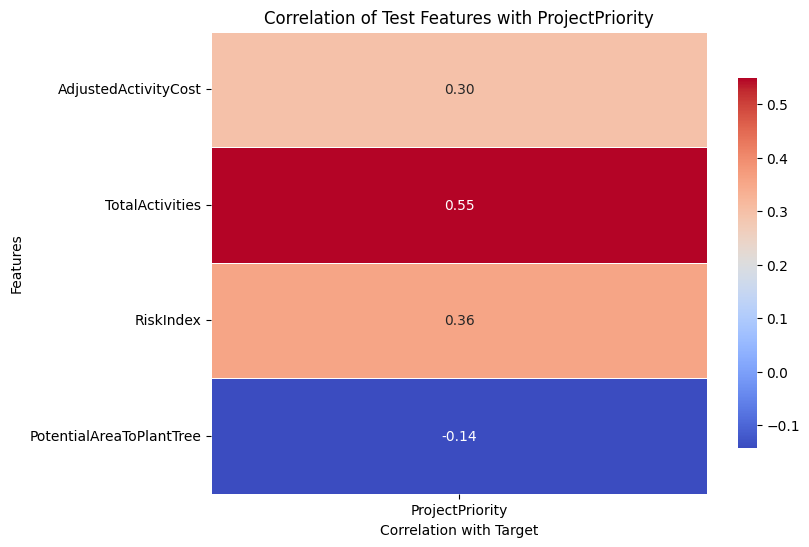

In [234]:
#Feature Correlation Heatmap: 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure X_test and y_test are DataFrames or Series, respectively
# Add y_test as a new column in X_test for correlation calculation
X_test_with_target = X_test.copy()
X_test_with_target['ProjectPriority'] = y_test_actual  # Replace 'ProjectPriority' with the actual target name if different

# Compute the correlation matrix
correlation_matrix = X_test_with_target.corr()

# Extract only correlations with the target column
target_correlation = correlation_matrix[['ProjectPriority']].drop('ProjectPriority')

# Plot the correlation with the target as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(target_correlation, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'shrink': .8}, linewidths=0.5)

# Customize plot
plt.title('Correlation of Test Features with ProjectPriority')
plt.xlabel('Correlation with Target')
plt.ylabel('Features')

# Show plot
plt.show()

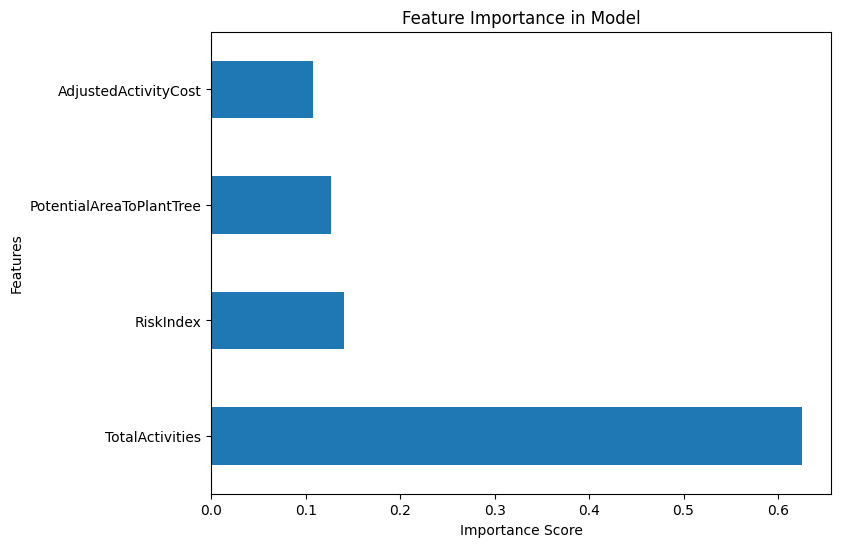

In [235]:
#Feature Importance Bar Charts
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(8, 6))
plt.title("Feature Importance in Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


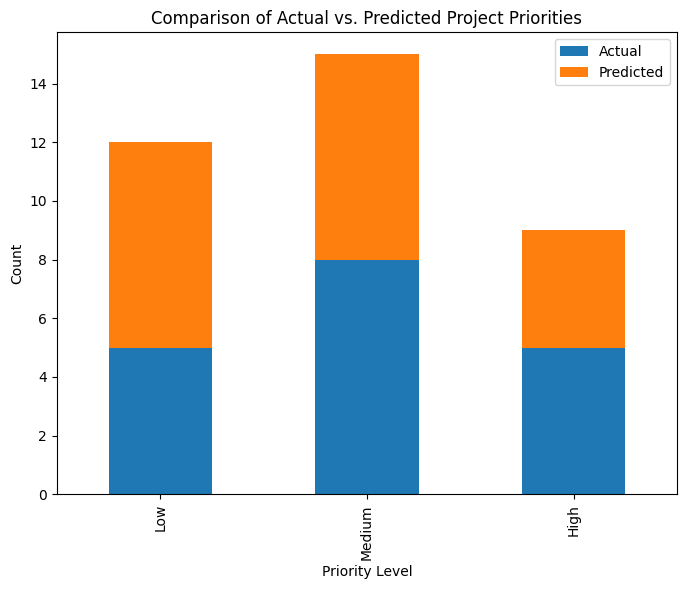

In [237]:
#•	Actual vs. Predicted Comparisons
priority_df.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title("Comparison of Actual vs. Predicted Project Priorities")
plt.xlabel("Priority Level")
plt.ylabel("Count")
plt.show()


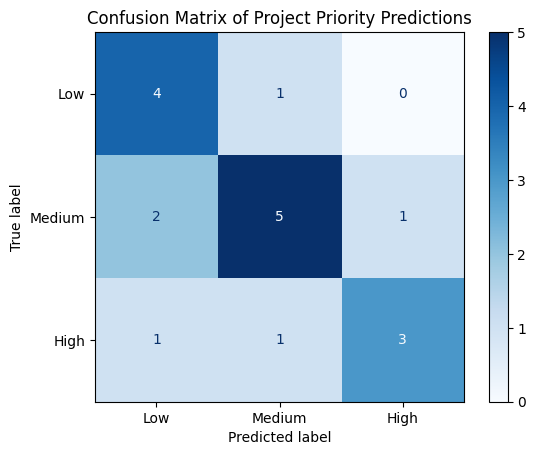

In [239]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, X_val, y_val, display_labels=["Low", "Medium", "High"], cmap="Blues")
plt.title("Confusion Matrix of Project Priority Predictions")
plt.show()

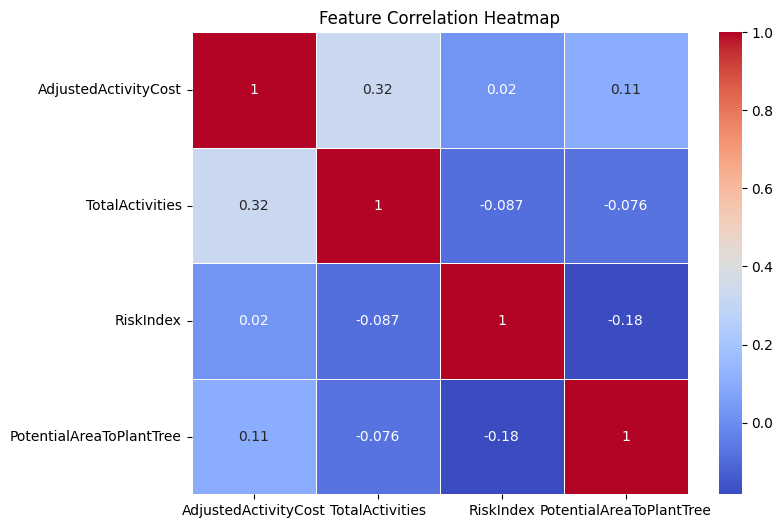

In [240]:
#Feature Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [241]:
###UNUSED CODE
# #ACAD data- we are only using regional for North america

# # Projects has 'SpeciesCommonName' and we want to match it with 'Common Name' in ACAD Regional
# acad_regional_df.rename(columns={'Common Name': 'SpeciesCommonName'}, inplace=True)
# # to create a new column 'Region_BCR' by prefixing 'BCR' to values in an existing column 'BCR'
# acad_regional_df['RegionName'] = acad_regional_df['BCR'].apply(lambda x: f'BCR{x}' if pd.notnull(x) else None)

# # Map Action Code to numerical scores
# action_code_mapping = {
#     'CR': 4,
#     'IM': 3,
#     'MA': 2,
#     'PR': 1
# }

# # Create a new column 'RegionalRiskIndex' initialized with Action Code values
# acad_regional_df['RegionalRiskIndex'] = acad_regional_df['Action Code'].map(action_code_mapping)

# # Convert relevant columns to numeric, forcing errors to NaN for non-numeric entries i.e. NULL
# for col in ['BD-g', 'PS-g', 'PT-r', 'TB-r', 'AI-b', 'ND-g', 'TN-r', 'AI-w']:
#     acad_regional_df[col] = pd.to_numeric(acad_regional_df[col], errors='coerce')

    
    
# # function to calculate Regional Risk Index where Action Code is null
# def calculate_regional_risk(row):
#     # Check if Action Code is null and required columns are not null
#     if pd.isnull(row['Action Code']):
#         breeding_season_sum = row[['BD-g', 'PS-g', 'PT-r', 'TB-r', 'AI-b']].sum()
#         nonbreeding_season_sum = row[['ND-g', 'PS-g', 'PT-r', 'TN-r', 'AI-w']].sum()
        
#         # Check if all necessary columns have values
#         if not row[['BD-g', 'PS-g', 'PT-r', 'TB-r', 'AI-b', 'ND-g', 'TN-r', 'AI-w']].isnull().any():
#             # Calculate regional risk index as the average of breeding and non-breeding scores
#             regional_risk = (breeding_season_sum + nonbreeding_season_sum) / 2
#             regional_risk = (regional_risk / 25) * 4  # Normalize to a scale of 0 to 4
#             return regional_risk
#         else:
#             # If any of the required columns is null, return 0 (no index)-least priority
#             return 0
#     else:
#         # If Action Code is not null, use the mapped score
#         return row['RegionalRiskIndex']


    
# # Apply the function to calculate RegionalRiskIndex for rows with null Action Code
# acad_regional_df['RegionalRiskIndex'] = acad_regional_df.apply(calculate_regional_risk, axis=1)
# # Check the output
# print(acad_regional_df[['SpeciesCommonName', 'Action Code', 'RegionalRiskIndex']].head(20))




# #merging projects with ACAD on species common name



# # Ensure both columns are in the same format (e.g., lowercase and stripped of extra whitespace)
# #Projects has been transformed to train_merged after aboe calcs
# acad_regional_df['SpeciesCommonName'] = acad_regional_df['SpeciesCommonName'].str.strip().str.lower()
# train_merged['SpeciesCommonName'] = train_merged['SpeciesCommonName'].str.strip().str.lower()

# acad_regional_df['RegionName'] = acad_regional_df['RegionName'].str.strip().str.lower()
# train_merged['RegionName'] = train_merged['RegionName'].str.strip().str.lower()

# # Merge train_merged with ACAD Regional on 'SpeciesCommonName' and 'RegionName'
# train_merged = pd.merge(train_merged, acad_regional_df[['SpeciesCommonName', 'RegionName', 'RegionalRiskIndex']],  on=['SpeciesCommonName', 'RegionName'], how='left')

# # Fill NaNs with 0 as if empty= means no priority as we dont have nay data for it
# train_merged['RegionalRiskIndex'].fillna(0, inplace=True)

# # Display the top rows to verify the merged result
# print(train_merged.head(50))
